In [2]:
from phonecodes import phonecodes
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from torch.nn import Transformer
from torch import Tensor
from sklearn.model_selection import train_test_split
import copy
import tqdm
import librosa
import seaborn as sns
import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
import textgrid
from scipy.spatial.distance import euclidean
import plotly.graph_objects as go
import pandas as pd
import jiwer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import nltk
nltk.download('cmudict')
from nltk.corpus import cmudict
from transformers import AutoProcessor, AutoModelForCTC
from phonemizer.backend.espeak.wrapper import EspeakWrapper
import soundfile as sf

_ESPEAK_LIBRARY = r"C:\Program Files\eSpeak NG\libespeak-ng.dll"
EspeakWrapper.set_library(_ESPEAK_LIBRARY)
processor_P = AutoProcessor.from_pretrained("facebook/wav2vec2-lv-60-espeak-cv-ft")
model_P = AutoModelForCTC.from_pretrained("facebook/wav2vec2-lv-60-espeak-cv-ft")


from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

[nltk_data] Downloading package cmudict to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Package cmudict is already up-to-date!
Some weights of the model checkpoint at facebook/wav2vec2-lv-60-espeak-cv-ft were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-lv-60-espeak-cv-ft and are newly initialized: ['wav2vec2.en

In [ ]:
def get_pathset(paths):
    return [os.path.join(dir, each_file) for dir, mid, files in os.walk(paths) for each_file in files if each_file.endswith(".wav")]

def create_set(audio_dir, df, model, processor):
    set1_list=[0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16]
    set2_list=[17,18,19,20,21,22,24,25,26,27,28,29,30,31,37,40]
    keywords_dict=get_keywords_dict(df)
    model.to(device)
    
    audio_path=get_pathset(audio_dir)
    out_dict={}
    
    for each_path in tqdm.tqdm(audio_path):
        current_talker=os.path.basename(each_path)[:-4]
        if current_talker not in out_dict.keys():
            out_dict[current_talker]=[]
        audio, sr = librosa.load(each_path)
        wave_res = librosa.resample(audio, orig_sr=sr, target_sr=16000)
        tg = textgrid.TextGrid.fromFile(each_path[:-3]+"TextGrid")
        tg_sentence = tg[0]
        for _,i in enumerate(tg[0]):
            if i.mark!="":
                tg_sentence[_-1].maxTime=tg_sentence[_].minTime
        tg_sentence = [i for i in tg_sentence if i.mark!=""]
        tg_sentence=[tg_sentence[i] for i in set1_list+set2_list]
        tg_word = [i for i in tg[1] if i.mark!="" and i.mark!="sp"]
        
        for _,each_sentence in enumerate(tg_sentence):
            each_sentence_list=[]
            start_sentence = int(each_sentence.minTime*16000)
            end_sentence = int(each_sentence.maxTime*16000)
            input=processor(wave_res[start_sentence:end_sentence], sampling_rate=16000, return_tensors="pt").input_values.to(device)
            with torch.no_grad():
                out_encoder=model(input).logits
                #out_FE=model.wav2vec2.feature_extractor(input)[0].transpose(1,0).cpu().numpy()
            outind=torch.argmax(out_encoder,dim=-1).cpu().numpy()
            
            out_encoder=copy.deepcopy(out_encoder).cpu().numpy()
            sentence_total_length=each_sentence.maxTime-each_sentence.minTime
            for key_word in list(keywords_dict.values())[_]:
                for each_word_tg in tg_word:
                    if each_word_tg.mark.lower()==key_word:
                        if each_word_tg.minTime >= each_sentence.minTime and each_word_tg.maxTime <= each_sentence.maxTime:                        
                            start=each_word_tg.minTime
                            end=each_word_tg.maxTime
                            break
                word_cut_start=start-each_sentence.minTime
                word_cut_end=end-each_sentence.minTime
                word_start=round(out_encoder.shape[1]*word_cut_start/sentence_total_length)
                word_end=round(out_encoder.shape[1]*word_cut_end/sentence_total_length)
                #cut or full.......
                indices=[_ for _,i in enumerate(outind[0]) if i>=5 and _>=word_start and _<=word_end]
                letter_label=[list(processor.tokenizer.get_vocab().keys())[i] for _,i in enumerate(outind[0]) if i>=5 and _>=word_start and _<=word_end]
                features=out_encoder[0,indices,:]
                each_sentence_list.append((letter_label, features))
            out_dict[current_talker].append(each_sentence_list)
        torch.cuda.empty_cache()
    torch.cuda.empty_cache()
    return out_dict


def get_keywords_dict(human_result_1a):
    '''
    Return a dict, key: sentenceID, values: keywords
    '''
    keywords_dict={}
    for each_ in human_result_1a.values:
        sentenceID=each_[human_result_1a.columns.get_loc("SentenceID")]
        if sentenceID not in keywords_dict:
            keywords_dict[sentenceID]=[]
        keyword=each_[human_result_1a.columns.get_loc("Keyword")]
        if keyword not in keywords_dict[sentenceID]:
            keywords_dict[sentenceID].append(keyword)
    return dict(sorted(keywords_dict.items()))

In [4]:
human_result_path=r"..\data\test.xlsx"
human_result = pd.read_excel(human_result_path)
human_result_1a=human_result[human_result["Experiment"]=="1a"]

In [5]:
audio_dir =r"..\Nov10\speech_files"
keywords_dict=create_set(audio_dir, human_result_1a, model_P, processor_P)

100%|██████████| 11/11 [00:10<00:00,  1.07it/s]


In [6]:
vector_data_set=[]
for key, values in keywords_dict.items():
    for each_sentence in values:
        for label, vectors in each_sentence:
            for vector in vectors:
                vector_data_set.append(vector)

In [7]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(np.array(vector_data_set))

In [8]:
keywords_dict1=copy.deepcopy(keywords_dict)
count=0
for key, values in keywords_dict.items():
    for _,each_sentence in enumerate(values):
        for __,(label, vectors) in enumerate(each_sentence):
            start=copy.deepcopy(count)
            for vector in vectors:
                count+=1
            #print(reduced_vectors[start:count,:].shape, vectors.shape)
            if reduced_vectors[start:count,:].shape[0] == vectors.shape[0]:
                keywords_dict1[key][_][__]=(label, reduced_vectors[start:count,:])
            else:
                print("ERROR")
                

In [9]:
keywords_dict1

{'ALL_016_M_CMN_ENG_HT1': [[(['b', 'oɪ'],
    array([[ -3.851803 , -12.162649 ,  12.916864 ],
           [ 20.566742 ,   1.4862133,  10.252455 ]], dtype=float32)),
   (['f', 'ɛ', 'l', 'l'],
    array([[ -6.070009 ,  -2.5342286,  17.428009 ],
           [ 13.139665 ,  13.225413 ,  -5.585814 ],
           [ -9.055137 , -10.727702 ,  -5.012478 ],
           [ -9.699325 , -12.630761 ,  -6.6932993]], dtype=float32)),
   (['w', 'ɪ', 'd', 'oʊ'],
    array([[ -1.5181204 , -20.703928  ,   1.5590318 ],
           [ -0.9672105 ,  11.575697  , -15.937223  ],
           [  4.7701716 ,   0.25180906,  10.299294  ],
           [ 20.977198  ,  -8.078862  ,   3.3088393 ]], dtype=float32))],
  [(['w', 'w', 'aɪ', 'f'],
    array([[ -2.254056  , -21.767334  ,  -0.1023076 ],
           [ -3.8971164 , -21.768738  ,  -1.7120211 ],
           [ 11.933175  ,   5.321852  ,   3.5087855 ],
           [ -2.522332  ,  -0.62355214,  22.197472  ]], dtype=float32)),
   (['h', 'ɛ', 'l', 'l', 'p', 't', 'h'],
    array([[

In [10]:

def sim_measure(df,keywords_dict, set_list, keywords):
    sim_max_list,sim_std_list,sim_mean_list =[], [], []
    
    for each_ in tqdm.tqdm(df.values):
        filename_loc=df.columns.get_loc("Filename")
        keyword_loc=df.columns.get_loc("Keyword")
        training_talker_loc=df.columns.get_loc("TrainingTalkerID")
        
        key_word = each_[keyword_loc]
        TrainingTalkerID = each_[training_talker_loc]
        sentenceID = each_[df.columns.get_loc("SentenceID")]
        
        testing_talker=os.path.basename(each_[filename_loc])[:-5]
        training_talker=each_[training_talker_loc].split(", ")
        
        sentence_ind=set_list.index(int(sentenceID[-3:])-1)
        keyword_ind=keywords[sentenceID].index(key_word)
        sim=[]
        for each_exposure in training_talker:
            exposure_talker=[i for i in list(keywords_dict.keys()) if each_exposure[-3:] in i][0]
            #print(testing_talker,sentenceID,sentence_ind,keyword_ind)
            X=keywords_dict[testing_talker][sentence_ind][keyword_ind][-1].transpose()
            Y=keywords_dict[exposure_talker][sentence_ind][keyword_ind][-1].transpose()
            if np.any(np.isnan(X)) or np.any(np.isnan(Y)):
                raise ValueError("Input sequences contain NaN values.")
            combined = np.hstack([X, Y])
            mean = np.mean(combined, axis=1, keepdims=True)
            std = np.std(combined, axis=1, keepdims=True)
            std[std == 0] = 1
            
            X_normalized = (X - mean) / std
            Y_normalized = (Y - mean) / std
            D, wp = librosa.sequence.dtw(X_normalized, Y_normalized, metric='euclidean')
                
            combined_length = X.shape[1] + Y.shape[1]
            normalized_distance = D[-1, -1] / combined_length
            sim.append(normalized_distance)
        sim_max_list.append(np.min(sim))
        sim_mean_list.append(np.mean(sim))
        
    return sim_max_list, sim_std_list, sim_mean_list
set1_list=[0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16]
set2_list=[17,18,19,20,21,22,24,25,26,27,28,29,30,31,37,40]
sim_max_list, sim_std_list, sim_mean_list=sim_measure(human_result_1a,keywords_dict1, set1_list+set2_list, get_keywords_dict(human_result_1a))

  0%|          | 0/16477 [00:00<?, ?it/s]

100%|██████████| 16477/16477 [00:03<00:00, 4453.97it/s]


In [11]:
human_result_1a["sim_max"]= np.exp(-0.02*np.array(sim_max_list))
human_result_1a["sim_mean"] = np.exp(-0.02*np.array(sim_mean_list))
human_result_1a.to_excel('similarities_w2v2P1024.xlsx')

C:\Users\Alex\AppData\Local\Temp\ipykernel_507836\2303561053.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_result_1a["sim_max"]= np.exp(-0.02*np.array(sim_max_list))
C:\Users\Alex\AppData\Local\Temp\ipykernel_507836\2303561053.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_result_1a["sim_mean"] = np.exp(-0.02*np.array(sim_mean_list))


<Figure size 1200x800 with 0 Axes>

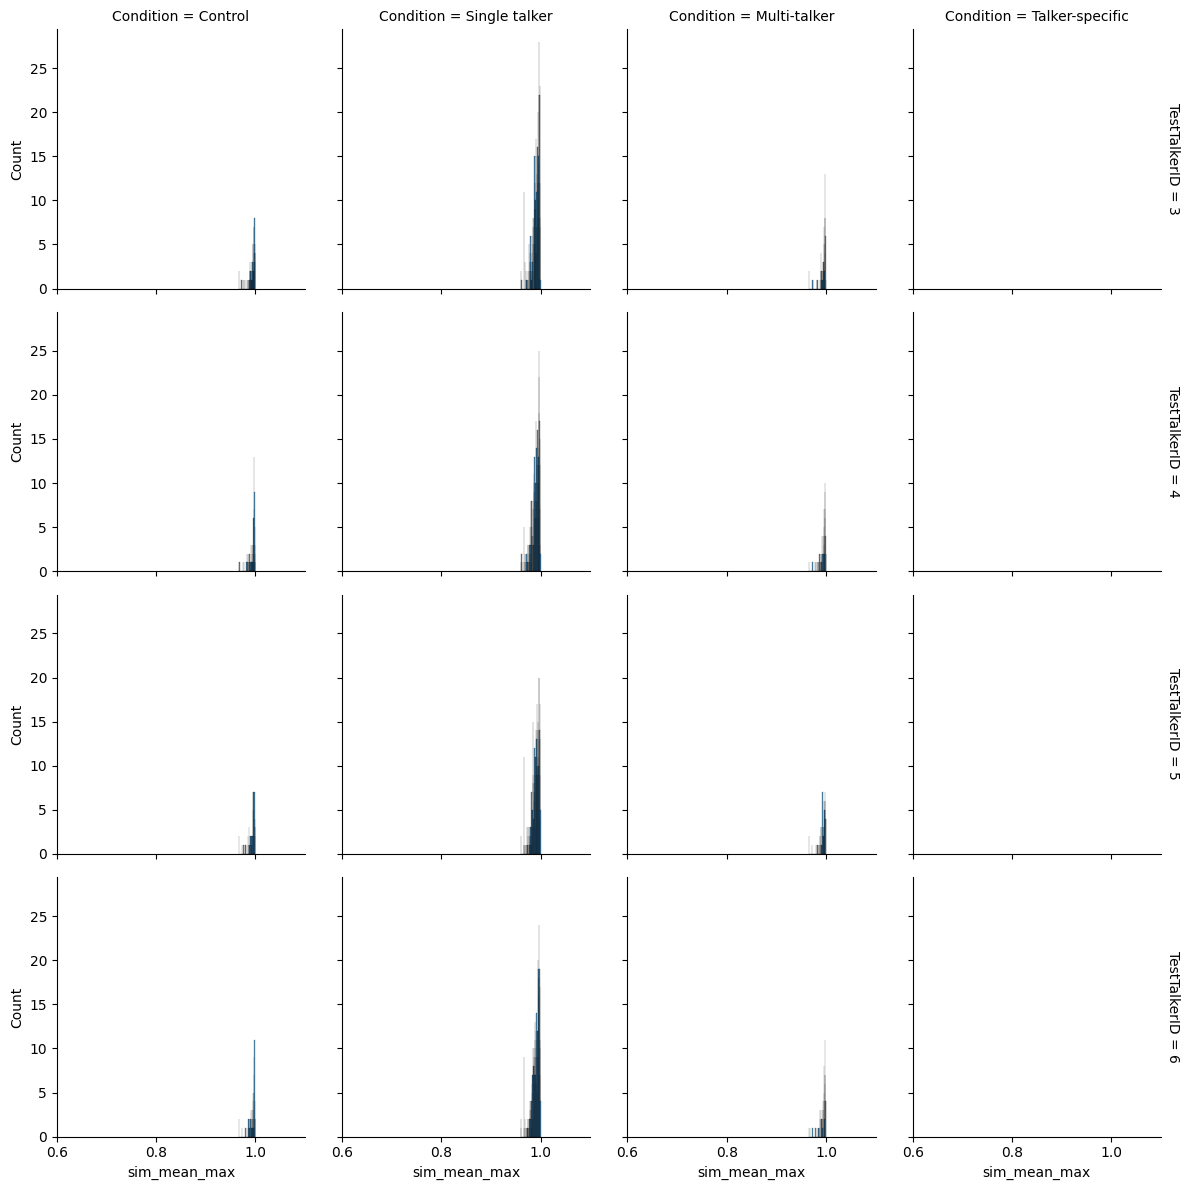

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
d_sim = pd.read_excel("./similarities_w2v2P1024.xlsx")
d_sim = d_sim[(d_sim['Experiment'] == '1a') & (d_sim['PartOfExp'] == 'test')]
d_sim = d_sim.rename(columns={'TrainingTalkerID': 'ExposureTalkerID'})
d_sim['ExposureTalkerID'] = d_sim.apply(
    lambda row: row['ExposureTalkerID'] if row['Condition2'] == 'Single talker' 
    else f"Exposure for {row['Condition2']} - TestTalkerID {row['TestTalkerID']}" if row['Condition2'] in ['Multi-talker', 'Talker-specific'] 
    else f"Exposure for {row['Condition2']}",
    axis=1
)
d_sim['KeywordID'] = pd.factorize(d_sim['Keyword'])[0] + 1
id_columns = ['WorkerID', 'ExposureTalkerID', 'TestTalkerID', 'SentenceID', 'KeywordID']
d_sim[id_columns] = d_sim[id_columns].astype('category')
d_sim['Condition'] = pd.Categorical(d_sim['Condition2'], categories=['Control', 'Single talker', 'Multi-talker', 'Talker-specific'], ordered=True)

grouped_sim = d_sim.groupby(['Condition', 'ExposureTalkerID', 'TestTalkerID', 'SentenceID', 'KeywordID']).agg(
    sim_mean_max=('sim_max', 'mean')
).reset_index()

single_talker_data = grouped_sim[grouped_sim['Condition'] == 'Single talker']
control_data = grouped_sim[grouped_sim['Condition'] == 'Control']
multi_talker_data = grouped_sim[grouped_sim['Condition'] == 'Multi-talker']
talker_specific_data = grouped_sim[grouped_sim['Condition'] == 'Talker-specific']
control_data_expanded = pd.concat([control_data] , ignore_index=True)
multi_talker_data_expanded = pd.concat([multi_talker_data] , ignore_index=True)
#talker_specific_data_expanded = pd.concat([talker_specific_data] * 10, ignore_index=True)
balanced_grouped_sim = pd.concat([single_talker_data, control_data_expanded, multi_talker_data_expanded], ignore_index=True)


plt.figure(figsize=(12, 8))
g = sns.FacetGrid(balanced_grouped_sim, row='TestTalkerID', col='Condition', margin_titles=True, sharex=True)
g.map(sns.histplot, 'sim_mean_max', bins=100)
g.set(xlim=(0.6, 1.1))
#g.set(ylim=(-0.1,15))
plt.tight_layout()
plt.show()



In [14]:
d_sim.groupby('Condition').agg(
    {col: 'mean' for col in d_sim.columns if col.startswith('sim')}
).reset_index()


,Condition,sim_max,sim_mean
0,Control,0.993546,0.990390
1,Single talker,0.990091,0.990091
2,Multi-talker,0.994223,0.990096
3,Talker-specific,1.000000,1.000000
